In [1]:
import ee

ee.Authenticate()


Successfully saved authorization token.


In [3]:
ee.Initialize(project="developerjose-glacier-mapping")

In [4]:
fishnet = ee.FeatureCollection("users/bibekaryal7/HKH/fishnet_clip")


In [3]:
# Catalog is in epsg:4326
import json

with open("../../catalog_v02.json") as file:
    df = json.load(file)
df

{'type': 'FeatureCollection',
 'name': 'catalog_v02_rgi',
 'features': [{'type': 'Feature',
   'properties': {'fill-opacity': 0.9848664555858357,
    'fill': 'red',
    'roi_percent_coverage': 1.5133544414164224,
    'geometry_epsg': {'type': 'Polygon',
     'coordinates': [[[400000, 4400000],
       [500000, 4400000],
       [500000, 4500000],
       [400000, 4500000],
       [400000, 4400000]]]},
    'datacube_exist': 1,
    'zarr_url': 'http://its-live-data.s3.amazonaws.com/datacubes/v2/S50W070/ITS_LIVE_vel_EPSG32718_G0120_X450000_Y4450000.zarr',
    'epsg': 32718,
    'FULL_NAME': 'Southern Andes',
    'RGI_CODE': 17},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-76.411339, -50.54338],
      [-75.0, -50.551932],
      [-75.0, -49.652543],
      [-76.385169, -49.644257],
      [-76.411339, -50.54338]]]}},
  {'type': 'Feature',
   'properties': {'fill-opacity': 0.9567409196571786,
    'fill': 'red',
    'roi_percent_coverage': 4.32590803428214,
    'geometry_epsg': {'typ

In [1]:
from pathlib import Path
from glacier_mapping.data.slice import read_tiff

for tiff_fpath in Path("/data/jperez/datasets/HKH_raw/Landsat7_2005").glob("*.tif"):
    tiff = read_tiff(tiff_fpath)

In [2]:
import pyproj
import xarray as xr
from shapely import geometry
from shapely.ops import transform
from datacube_tools import DATACUBETOOLS

dct = DATACUBETOOLS()

# Prepare to convert between TIFF crs and catalog crs
# https://gis.stackexchange.com/questions/127427/transforming-shapely-polygon-and-multipolygon-objects
tiff_crs = pyproj.CRS(tiff.meta['crs'])
catalog_crs = pyproj.CRS('EPSG:4326')
project = pyproj.Transformer.from_crs(tiff_crs, catalog_crs, always_xy=True).transform

# Convert bounds of tiff to match catalog
xmin, ymin, xmax, ymax = tiff.bounds
result = dct.get_subcube_for_bounding_box([xmin, ymin, xmax, ymax], 32643)
# bounds = geometry.box(*tiff.bounds)
# bounds = transform(project, bounds)
# print(bounds)

# # Inspired by https://github.com/nasa-jpl/its_live/blob/558db0b77f3bb845eb262ebbb2869006d1ec5c76/notebooks/datacube_tools.py
# best_matching_cube = None
# best_iou = -1
# for cube_info in df["features"]:
#     cube_geom = geometry.shape(cube_info["geometry"])
#     intersection = cube_geom.intersection(bounds).area
#     union = cube_geom.union(bounds).area
#     iou = intersection / union
#     if iou > best_iou:
#         best_iou = iou
#         best_matching_cube = cube_info

# print(best_iou, best_matching_cube)


original xy [764865.0, 3793425.0] 32643 maps to datacube (764865.0, 3793425.0) EPSG:32643
32643 32643
Loading subset cube...


In [30]:
zarr_path = best_matching_cube["properties"]["zarr_url"].replace("http:", "s3:").replace(".s3.amazonaws.com", "")
print(zarr_path)

s3://its-live-data/datacubes/v2/N30E070/ITS_LIVE_vel_EPSG32643_G0120_X750000_Y3750000.zarr


In [31]:
# http://its-live-data.s3.amazonaws.com/datacubes/v2/S60E100/ITS_LIVE_vel_EPSG3031_G0120_X2250000_Y-750000.zarr
# ds = xr.open_dataset("s3://its-live-data/datacubes/v2/S60E100/ITS_LIVE_vel_EPSG3031_G0120_X2250000_Y-750000.zarr", engine="zarr", storage_options={"anon": True})
ds = xr.open_dataset(zarr_path, engine="zarr", storage_options={"anon": True})


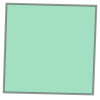

In [32]:
bounds

In [66]:
pt1 = list(bounds.exterior.coords)[0]
print(pt1)

pt_dataset = ds["vx"].sel(x=pt1[1], y=pt1[0], method="nearest")
print(pt_dataset[:5].to_numpy())
pt_dataset

(78.1251328681506, 33.98620305596169)
[nan nan nan nan nan]


<xarray.DataArray 'vx' (mid_date: 73750)> Size: 295kB
[73750 values with dtype=float32]
Coordinates:
  * mid_date  (mid_date) datetime64[ns] 590kB 2022-04-14T17:38:15.220210944 ....
    x         float64 8B 7.001e+05
    y         float64 8B 3.7e+06
Attributes:
    description:    velocity component in x direction
    grid_mapping:   mapping
    standard_name:  land_ice_surface_x_velocity
    units:          meter/year